In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings; warnings.simplefilter('ignore')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import rstoolbox
import pandas as pd
import seaborn as sns
import numpy as np
import copy
import glob
import os

sns.set(font_scale=3)
matplotlib.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

# Scaffold Search

For each motif of interest, we perform a [_master_](http://www.grigoryanlab.org/master/) search over the __PDBnr30__ database provided by _master_ and then we use _Rosetta_ to place the binder of the motif according to the motif alignment to the matched scaffold, clean the sidechains, and evaluate clashes.

|__INFO__|__H__|__E__|__HLH__|__ELE__|__HLE__|__HxL__|
|:------:|:---:|:---:|:-----:|:-----:|:-----:|:-----:|
|Query   |2fx7 |3o41 |3ixt   |3vtt   |5tpn   |4jhw   |
|Match   |1z6n |     |3lhp   |3wei   |       |       |
|Design  |3lef |     |4l8i   |4x42   |       |       |
||![2fx7](images/2fx7.png)|![3o41](images/3o41.png)|![3ixt](images/3ixt.png)|![3vtt](images/3vtt.png)|![5tpn](images/5tpn.png)|![4jhw](images/4jhw.png)|

In [3]:
dfs ={"5tpn": 1, "2fx7": 1, "3ixt": 1, "3vtt": 1, "3o41": 1, "4jhw": 1}
for k in dfs:
    if not isinstance(dfs[k], int):
        continue
    dfs[k] = pd.read_csv(os.path.join(k, "master_search.csv.gz"))
    if os.path.isfile(os.path.join(k, "ddg_match.csv.gz")):
        tmp = pd.read_csv(os.path.join(k, "ddg_match.csv.gz"))
        dfs[k] = dfs[k].merge(tmp, how="left", on=["cluster", "str"])
    print("read {}".format(k))
total_master_list = 17539

read 3ixt
read 2fx7
read 4jhw
read 3o41
read 5tpn
read 3vtt


In [47]:
def plot( df, maxim, title, ax, known=None, knames=None, kcolor=None, annotate=False, top=10, rmsd_lim=5 ):
    allvalues = df[df["pdb"] != "eeee"].sort("rmsd").groupby(["pdb","chain"]).head(1)[["rmsd"]].values
    allv_raw, allv_y, allv_x = rstoolbox.analysis.cumulative(allvalues, max_count=maxim, upper_limit=rmsd_lim)
    ax.plot(allv_x, allv_y, color=sns.color_palette()[0], lw=4)
    if annotate:
        idx = (np.abs(np.array(allv_raw)-top)).argmin()
        ax.axvline(x=allv_x[idx], ymin=0, ymax=0.2, c=sns.color_palette()[0], linewidth=4, linestyle="dashed", zorder=10)
        ax.plot([allv_x[idx]], [0.2], 'o', c=sns.color_palette()[0], markersize=12)
    if "ddg" in df:
        ddgvalues = df[(df["pdb"] != "eeee") & (df["ddg"] <= 0) ].sort("rmsd").groupby(["pdb","chain"]).head(1)[["rmsd"]].values
        ddgv_raw, ddgv_y, ddgv_x = rstoolbox.analysis.cumulative(ddgvalues, max_count=maxim, upper_limit =rmsd_lim)
        ax.plot(ddgv_x, ddgv_y, color=sns.color_palette()[1], lw=4)
        #ax.fill(ddgv_x, ddgv_y, facecolor=sns.color_palette()[1], alpha=0.5)
        ax.fill_between(ddgv_x, 0, ddgv_y, color=sns.color_palette()[1], alpha=0.5)
        if annotate:
            idx = (np.abs(np.array(ddgv_raw)-top)).argmin()
            ax.axvline(x=ddgv_x[idx], ymin=0, ymax=0.2, c=sns.color_palette()[1], linewidth=4, linestyle="dashed", zorder=10)
            ax.plot([ddgv_x[idx]], [0.2], 'o', c=sns.color_palette()[1], markersize=12)
    if known is not None:
        for i, k in enumerate(known):
            ax.axvline(x=k, ymin=0, ymax=1, c=kcolor[i], linewidth=2, linestyle="dashed", zorder=10)
    if knames is not None:
        for i, k in enumerate(knames):
           ax.text(known[i] - 0.3, 0.8 - (0.06 * i), k, color=kcolor[i], horizontalalignment='center', size='x-small', weight='semibold')
    ax.text(4.02, 0.15, "n = {}".format(maxim), color="black", horizontalalignment='left', size='x-small', weight='semibold')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 5)
    ax.set_xlabel("RMSD")
    ax.set_ylabel("")
    ax.annotate(title, xy=(0.5, 1), xytext=(0, 5), xycoords='axes fraction',
                textcoords='offset points', ha='center', va='baseline')

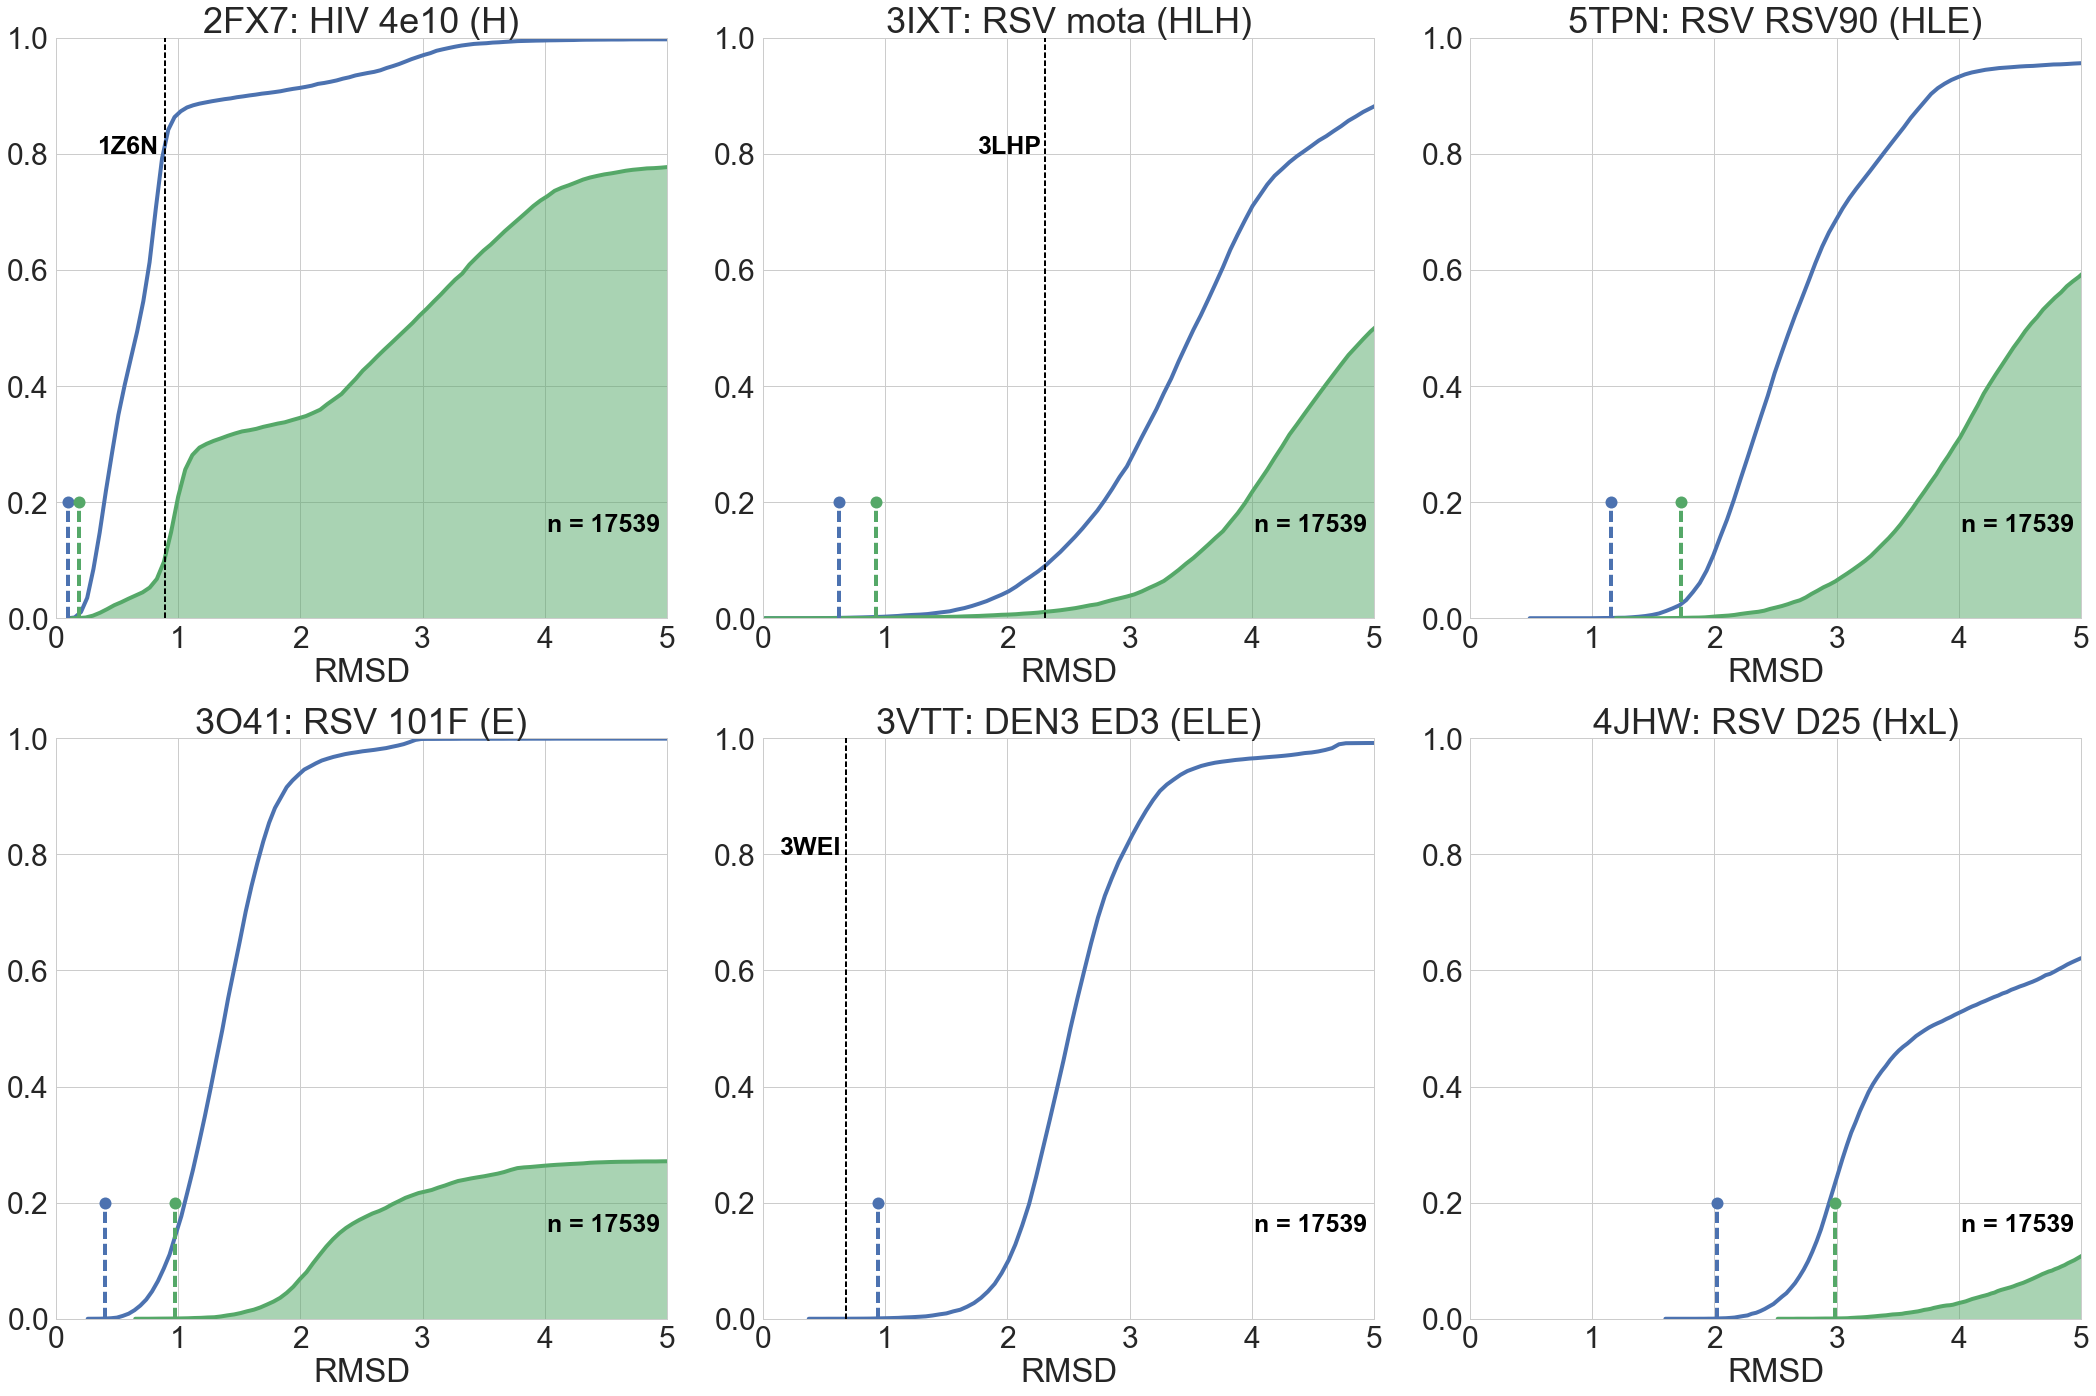

In [48]:
fig  = plt.figure(figsize=(30, 20))
grid = (2, 3)
ax11 = plt.subplot2grid(grid, (0, 0))
ax12 = plt.subplot2grid(grid, (0, 1))
ax13 = plt.subplot2grid(grid, (0, 2))
ax21 = plt.subplot2grid(grid, (1, 0))
ax22 = plt.subplot2grid(grid, (1, 1))
ax23 = plt.subplot2grid(grid, (1, 2))
if isinstance(dfs["2fx7"], pd.DataFrame):
    plot( dfs["2fx7"], total_master_list, "2FX7: HIV 4e10 (H)",    ax11, [0.89], ["1Z6N"], kcolor=["black"], annotate=True )
if isinstance(dfs["3ixt"], pd.DataFrame):
    plot( dfs["3ixt"], total_master_list, "3IXT: RSV mota (HLH)",  ax12, [2.31], ["3LHP"], kcolor=["black"], annotate=True )
if isinstance(dfs["5tpn"], pd.DataFrame):
    plot( dfs["5tpn"], total_master_list, "5TPN: RSV RSV90 (HLE)", ax13, annotate=True )
if isinstance(dfs["3o41"], pd.DataFrame):
    plot( dfs["3o41"], total_master_list, "3O41: RSV 101F (E)",    ax21, annotate=True )
if isinstance(dfs["3vtt"], pd.DataFrame):
    plot( dfs["3vtt"], total_master_list, "3VTT: DEN3 ED3 (ELE)",  ax22, [0.68], ["3WEI"], kcolor=["black"], annotate=True )
if isinstance(dfs["4jhw"], pd.DataFrame):
    plot( dfs["4jhw"], total_master_list, "4JHW: RSV D25 (HxL)",   ax23, annotate=True )

plt.tight_layout()
plt.savefig("images/motif_recovery.svg")
plt.savefig("images/motif_recovery.png")
sns.plt.show()

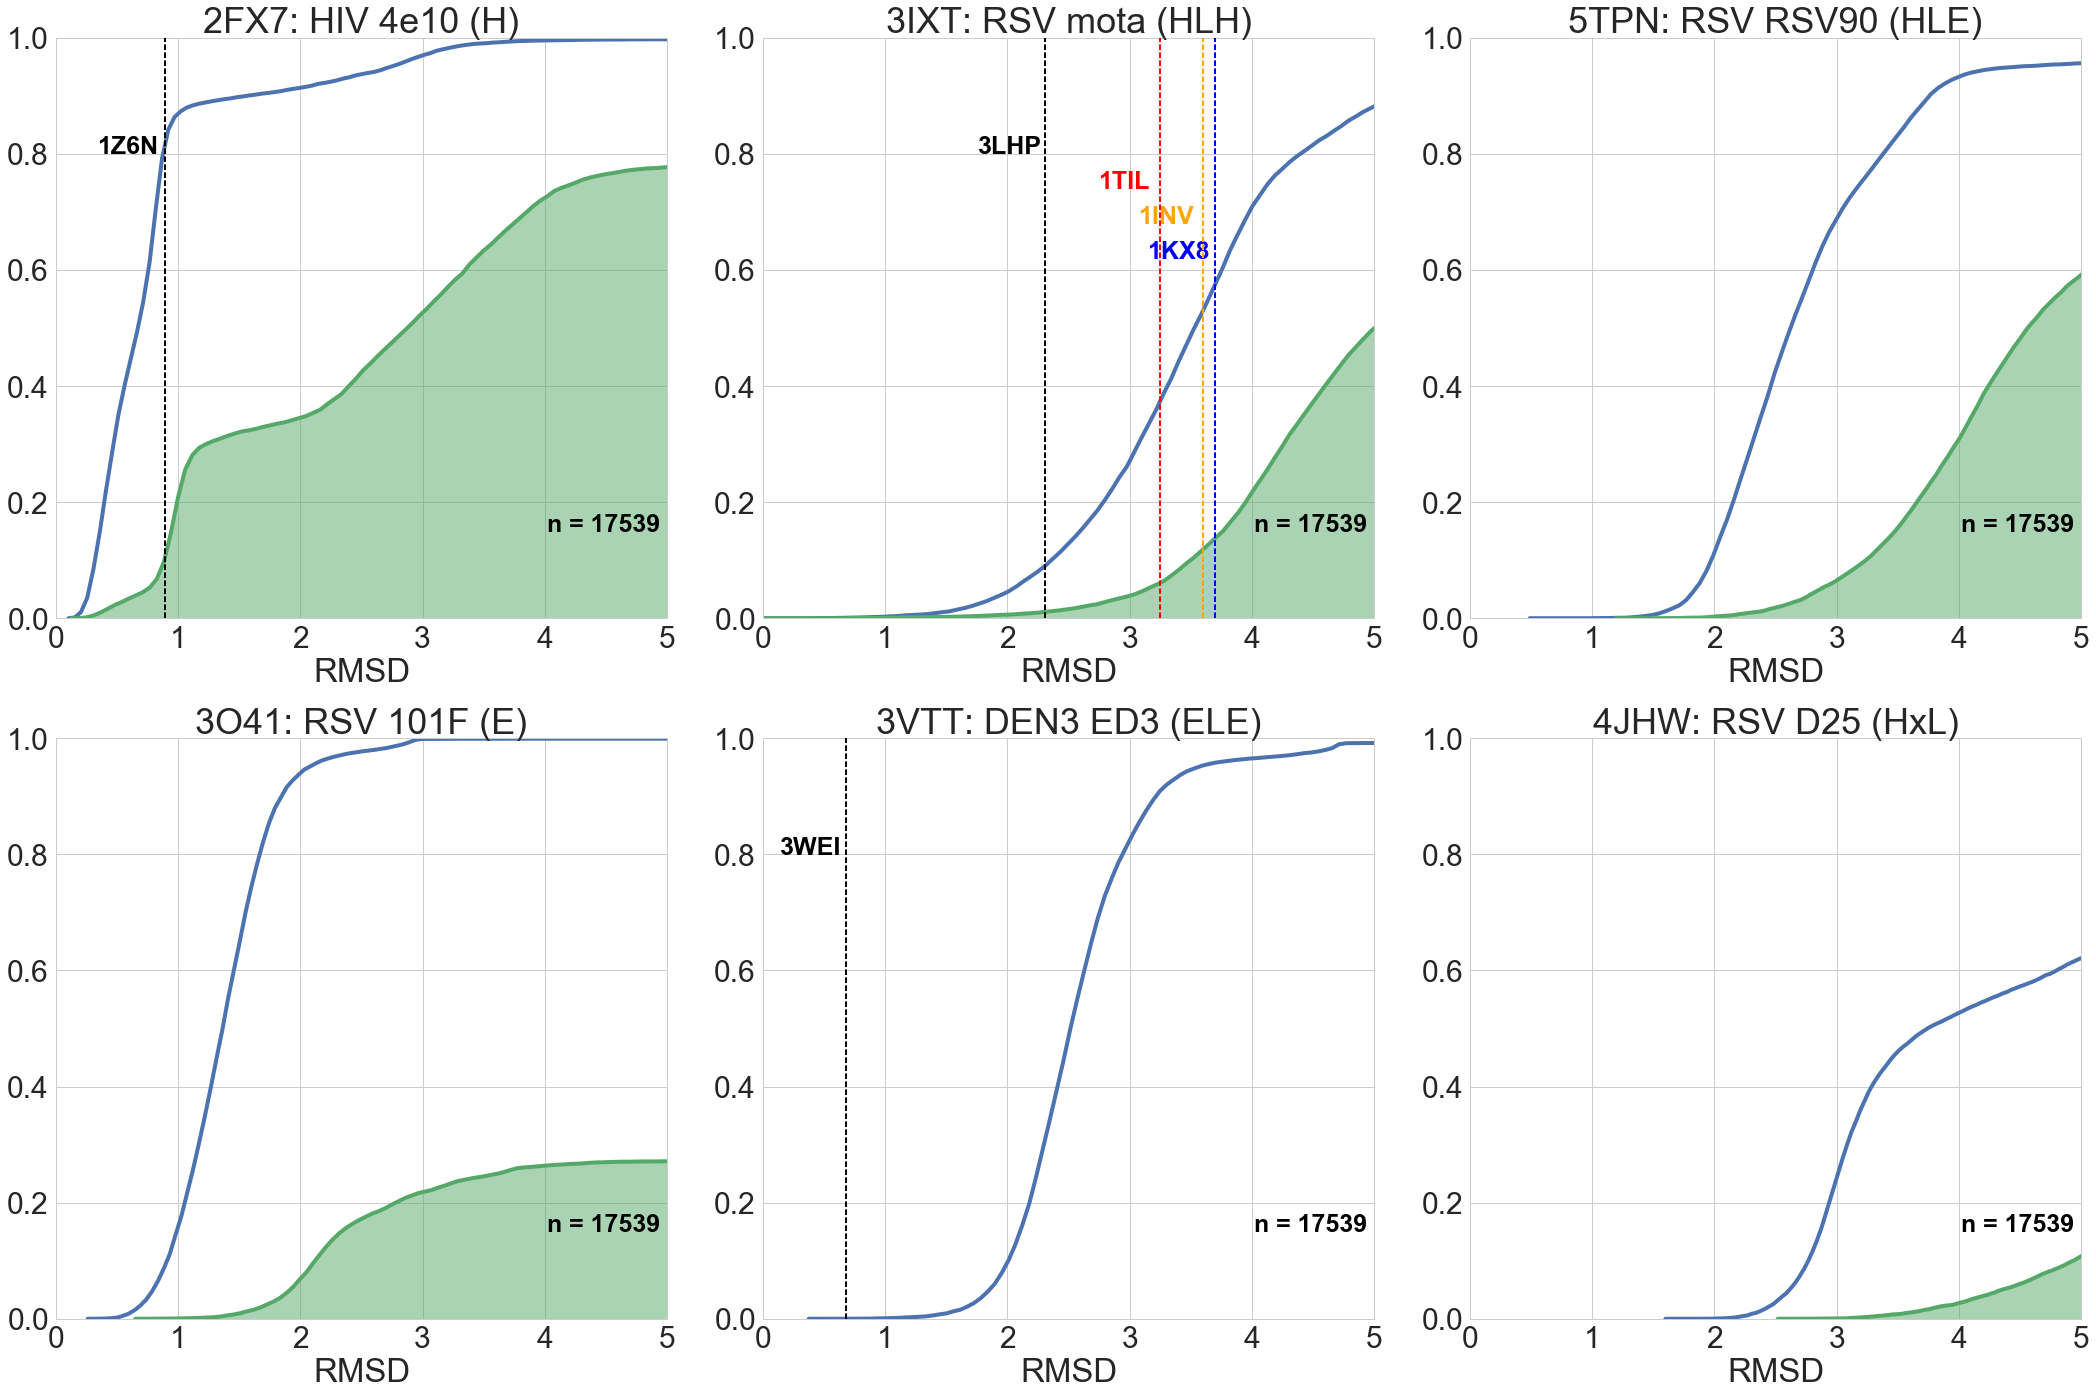

In [49]:
fig  = plt.figure(figsize=(30, 20))
grid = (2, 3)
ax11 = plt.subplot2grid(grid, (0, 0))
ax12 = plt.subplot2grid(grid, (0, 1))
ax13 = plt.subplot2grid(grid, (0, 2))
ax21 = plt.subplot2grid(grid, (1, 0))
ax22 = plt.subplot2grid(grid, (1, 1))
ax23 = plt.subplot2grid(grid, (1, 2))
plot( dfs["2fx7"], total_master_list, "2FX7: HIV 4e10 (H)",    ax11, [0.89], ["1Z6N"], kcolor=["black"] )
plot( dfs["3ixt"], total_master_list, "3IXT: RSV mota (HLH)",  ax12, [2.31, 3.25, 3.6, 3.7], ["3LHP", "1TIL", "1INV", "1KX8"], kcolor=["black", "red", "orange", "blue"] )
plot( dfs["5tpn"], total_master_list, "5TPN: RSV RSV90 (HLE)", ax13 )
plot( dfs["3o41"], total_master_list, "3O41: RSV 101F (E)",    ax21 )
plot( dfs["3vtt"], total_master_list, "3VTT: DEN3 ED3 (ELE)",  ax22, [0.68], ["3WEI"], kcolor=["black"] )
plot( dfs["4jhw"], total_master_list, "4JHW: RSV D25 (HxL)",   ax23 )
plt.tight_layout()
plt.savefig("images/motif_recovery_with_designs.svg")
plt.savefig("images/motif_recovery_with_designs.png")
sns.plt.show()